In [1]:
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np
import jax
import RestrictedNbody
jax.config.update("jax_enable_x64", True)


In [2]:
pot_NFW = potential.NFWPotential(m=1e12,r_s=20.0,units=usys)
ts = jnp.linspace(0,3000,1000)#1500)
w0=jnp.array([20.,20.,20.,.1,.1,-.05])
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=True )


In [3]:
np.random.seed(49202)
N = 30_000
ics = jnp.hstack([np.random.normal(loc=0,scale=.01,size=(N,3)), np.random.normal(loc=0,scale=.001,size=(N,3))])


ics = ics + sol.evaluate(0.0)

prog_pot = potential.PlummerPotential
ts = jnp.array([0.0,3000.0])
interrupt_ts = jnp.arange(50,3000,50)#jnp.linspace()
field_init = RestrictedNbody.RestrictedNbody_generator(potential=pot_NFW, progenitor_potential=prog_pot, interp_prog=sol, init_mass=100.0, init_rs=0.01,  
r_esc=.5,maxiter=10_000, lr=1e-3)
init_mass, init_r_s = RestrictedNbody.initialize_prog_params(w0=ics,t0=ts[0],field=field_init)
#field_init.get_params(0.0, ics,None)


In [27]:
init_mass, init_r_s

In [ ]:

out = jax.block_until_ready(
    RestrictedNbody.integrate_restricted_Nbody(w0=ics, ts=ts, field=field_init, interrupt_ts=interrupt_ts, 
maxiter=2, mass_init=init_mass, r_s_init=init_r_s, solver=diffrax.Tsit5(scan_kind='bounded'),dtmin=0.5, rtol=1e-6, atol=1e-6)
)

Text(0, 0.5, '$M_{\\rm prog}$ [Msun]')

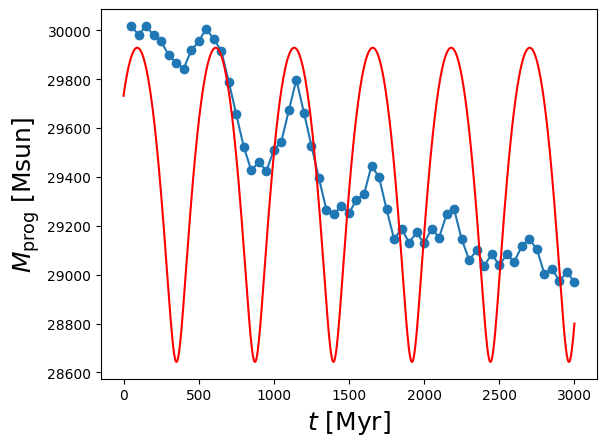

In [37]:
teval = jnp.linspace(ts.min(),ts.max(),1000)
X_orb = jax.vmap(sol.evaluate)(teval)
r_orb = jnp.sqrt(jnp.sum(X_orb[:,:3]**2,axis=1))

plt.plot(out[0], out[1],marker='o')
plt.plot(teval, 50*(r_orb)+28_000,color='r')
plt.xlabel(r'$t$ [Myr]',fontsize=18)
plt.ylabel(r'$M_{\rm prog}$ [Msun]',fontsize=18)

Text(0, 0.5, '$r_s$ [pc]')

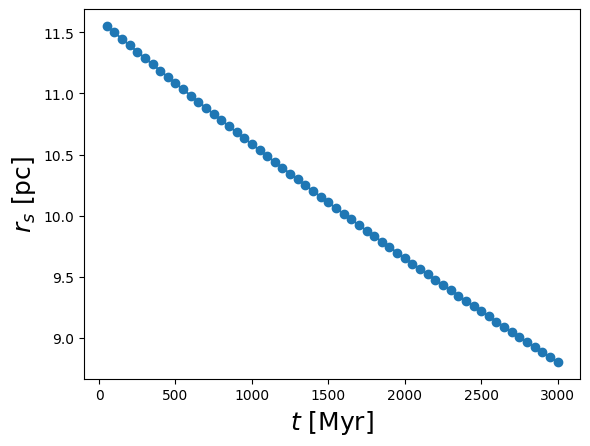

In [38]:
teval = jnp.linspace(ts.min(),ts.max(),1000)
X_orb = jax.vmap(sol.evaluate)(teval)
r_orb = jnp.sqrt(jnp.sum(X_orb[:,:3]**2,axis=1))

plt.plot(out[0], out[2]*1000,marker='o')
#plt.plot(teval, 1*(r_orb)+0,color='r')
plt.xlabel(r'$t$ [Myr]',fontsize=18)
plt.ylabel(r'$r_s$ [pc]',fontsize=18)

(-10.0, 28.0)

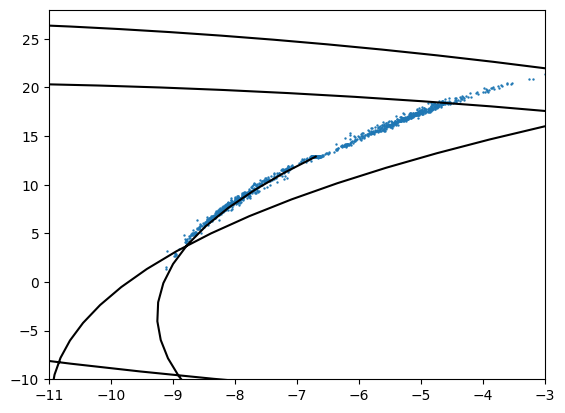

In [39]:
t_ind = -1
path = jax.vmap(sol.evaluate)(jnp.linspace(ts.min(),ts.max(),500))
plt.plot(path[:,0], path[:,2], color='black',zorder=3)
plt.scatter(out[-1][t_ind,:,0], out[-1][t_ind,:,2], s=.5,zorder=-3)
plt.xlim(-11,-3)
plt.ylim(-10,28)



In [4]:
pot_NFW = potential.NFWPotential(m=1e12,r_s=20.0,units=usys)

In [5]:
ts = jnp.linspace(0,3000,1000)#1500)
w0=jnp.array([20.,0.,20.,.0,.2,.0])
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=True )



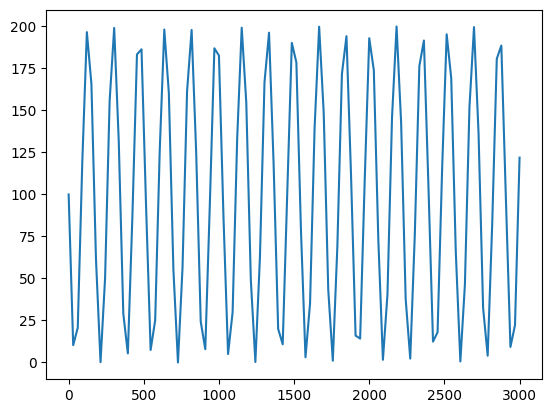

In [6]:
import interpax
t_coord= jnp.linspace(0,3000,100)
mass_coord = jnp.sin(t_coord)*100 + 100
mass_spl = interpax.CubicSpline(t_coord,mass_coord)
plt.plot(t_coord, mass_spl(t_coord))

r_s_coord = jnp.sin(t_coord)*0.1 + 0.5
r_s_spl = interpax.CubicSpline(t_coord,r_s_coord)
prog_pot =  potential.PlummerPotential
pot_test = potential.TimeDepProgenitorPotential(mass_spl=mass_spl, r_s_spl=r_s_spl, interp_func=sol, prog_pot=prog_pot, units=usys)


In [7]:
pot_test.potential(jnp.array([1.,2.,3]),10.0)

Array(-1.06623992e-11, dtype=float64)

In [8]:
hamiltonian_field = fields.hamiltonian_field(pot_NFW)
hamiltonian_field.term(0.0,jnp.array([1.,2.,3.,.2,.3,.4]), None)

Array([ 0.2       ,  0.3       ,  0.4       , -0.0011937 , -0.00238739,
       -0.00358109], dtype=float64)

In [9]:
kwargs = {'rtol':1e-6,'atol':1e-6,}


In [10]:
field_orb = fields.integrate_field(w0=w0, ts=ts,field=hamiltonian_field, backwards_int=False)
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=False , **kwargs)


sol2 = pot_NFW.integrate_orbit(w0=w0+.01, ts=ts,dense=False , **kwargs)


In [11]:
field_orb.ys

Array([[ 2.00000000e+01,  0.00000000e+00,  2.00000000e+01,
         0.00000000e+00,  2.00000000e-01,  0.00000000e+00],
       [ 1.99947007e+01,  6.00547553e-01,  1.99947007e+01,
        -3.52920125e-03,  1.99947006e-01, -3.52920125e-03],
       [ 1.99788050e+01,  1.20077683e+00,  1.99788050e+01,
        -7.05704492e-03,  1.99788029e-01, -7.05704492e-03],
       ...,
       [ 1.54653741e+01, -1.50646962e+01,  1.54653741e+01,
         9.87262702e-02,  1.62473824e-01,  9.87262702e-02],
       [ 1.57572297e+01, -1.45723635e+01,  1.57572297e+01,
         9.56423786e-02,  1.65401168e-01,  9.56423786e-02],
       [ 1.60397604e+01, -1.40714069e+01,  1.60397604e+01,
         9.25163046e-02,  1.68217294e-01,  9.25163046e-02]],      dtype=float64)

In [12]:
sol.ys.sum()

Array(-936.42809302, dtype=float64)

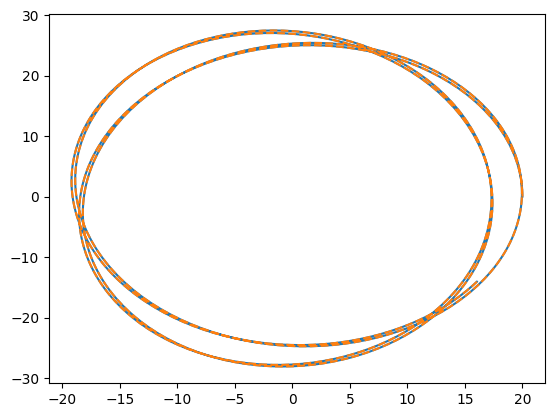

In [13]:
plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [14]:
kwargs = {'rtol':1e-8}


ts.shape

(1000,)

In [15]:
l, t = pot_NFW.gen_stream_scan(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493,kval_arr=1.0) 

In [16]:
#lv, tv = pot_NFW.gen_stream_vmapped(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, **kwargs)

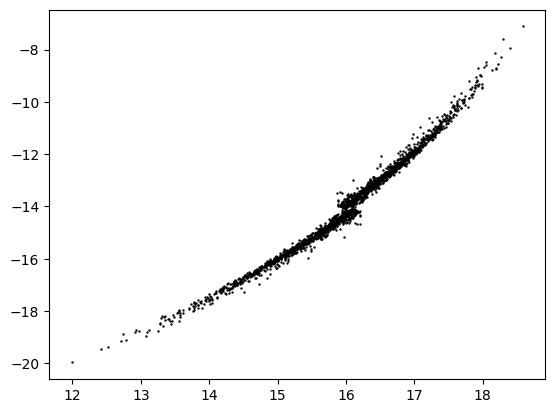

In [17]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

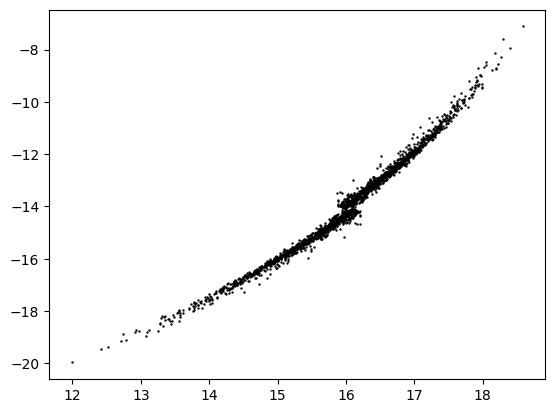

In [18]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

#plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

#plt.scatter(lv[:,0], lv[:,1],s=0.5,color='r')
#plt.scatter(tv[:,0], tv[:,1],s=0.5,color='r')

In [19]:
kwargs = {'rtol':1e-5, 'atol':1e-5}

In [20]:
diffrax.Tsit5(scan_kind="bounded")

Tsit5(scan_kind='bounded')

In [21]:
ld_td = pot_NFW.gen_stream_scan_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, solver=diffrax.Bosh3())

In [22]:
ld_td

Solution(
  t0=f64[999,2],
  t1=f64[999,2],
  ts=None,
  ys=None,
  interpolation=DenseInterpolation(
    ts=f64[999,2,10001],
    ts_size=weak_i64[999,2],
    infos={
      'k':
      f64[999,2,10000,4,6],
      'y0':
      f64[999,2,10000,6],
      'y1':
      f64[999,2,10000,6]
    },
    interpolation_cls=<bound method ThirdOrderHermitePolynomialInterpolation.from_k of <class 'diffrax._local_interpolation.ThirdOrderHermitePolynomialInterpolation'>>,
    direction=weak_i64[999,2],
    t0_if_trivial=f64[999,2],
    y0_if_trivial=f64[999,2,6]
  ),
  stats={
    'max_steps':
    weak_i64[999,2],
    'num_accepted_steps':
    weak_i64[999,2],
    'num_rejected_steps':
    weak_i64[999,2],
    'num_steps':
    weak_i64[999,2]
  },
  result=EnumerationItem(
    _value=i32[999,2],
    _enumeration=<class 'diffrax._solution.RESULTS'>
  ),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)

In [23]:
import equinox as eqx
ind = 28
arr, narr = eqx.partition(ld_td, eqx.is_array)
arr = jax.tree_util.tree_map(lambda x: x[ind,0], arr)
interp = eqx.combine(arr, narr)

eval_func_lead = interp.evaluate
eval_func_lead(3000.0)

Array([ 17.3211999 , -11.06826346,  17.35757815,   0.07440228,
         0.18153357,   0.07453322], dtype=float64)

In [24]:
ld, td = StreamSculptor.eval_dense_stream(2200.0, ld_td)

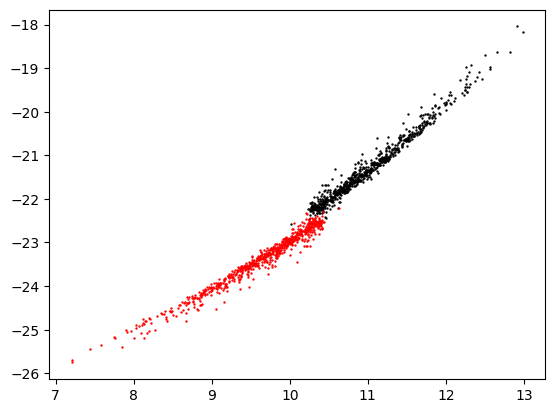

In [25]:
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')


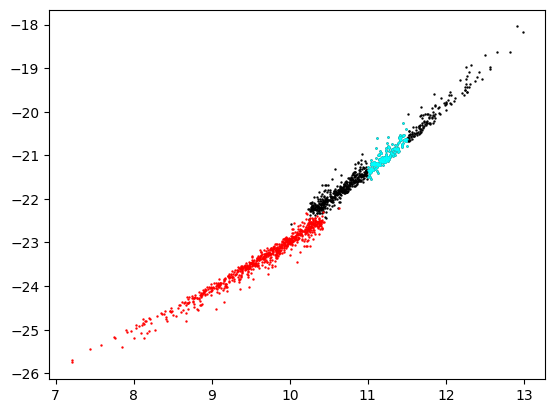

In [26]:
in_bool = (ld[:,0]>11) & (ld[:,0]<11.5)
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')

plt.scatter(ld[in_bool,0], ld[in_bool,1],s=0.5,color='cyan')

x0v0_SH = jnp.mean(ld[in_bool,:],axis=0)

In [27]:
x0v0_SH.shape

(6,)

In [28]:
#ldv_tdv = pot_NFW.gen_stream_vmapped_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493,solver=diffrax.Bosh3(scan_kind='bounded'), **kwargs)

In [29]:
#ldv, tdv = StreamSculptor.eval_dense_stream(500.0, ldv_tdv)


In [30]:
#plt.scatter(ldv[:,0], ldv[:,1],s=0.5,color='k')
#plt.scatter(tdv[:,0], tdv[:,1],s=0.5,color='k')


In [31]:
from perturbative import GenerateMassRadiusPerturbation, BaseStreamModel

In [32]:
## Subhalo potential
np.random.seed(3022)
N = 10
M = jnp.zeros(N)
M = M.at[0].set(1.0)
a = jnp.ones(N)*.2
subhalo_x0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))

subhalo_x0 = subhalo_x0.at[0].set(x0v0_SH[:3])
subhalo_v = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))
subhalo_v = subhalo_v.at[0].set(x0v0_SH[3:] + jnp.array([0.05,0.001,.0]))

np.random.seed(30222)
subhalo_t0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,)))*0.0 #jnp.ones(N)*0.0
subhalo_t0 = subhalo_t0.at[0].set(2200.0)
t_window = jnp.ones(N)*250.0

pot_SH = potential.SubhaloLinePotential(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)
pot_structural = potential.SubhaloLinePotential_dRadius(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)

pot_structural.potential(jnp.array([1.,2,3.]),0.0)


Array(0., dtype=float64)

In [33]:
pot_SH.potential_per_SH(jnp.array([2,3,4.]),2200.0)

Array([-1.68303436e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00], dtype=float64)

In [34]:
base_model = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, 
solver=diffrax.Dopri5(scan_kind='bounded'), dtmin=.5, dtmax=None, dense=False, cpu=True )

/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [35]:
pert_Gen = GenerateMassRadiusPerturbation(potential_base=pot_NFW,potential_perturbation=pot_SH,
potential_structural=pot_structural, units=usys,BaseStreamModel=base_model,solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9, atol=1e-9,dtmin=0.01,dtmax=None)#,dtmin=0.01,dtmax=2.0)

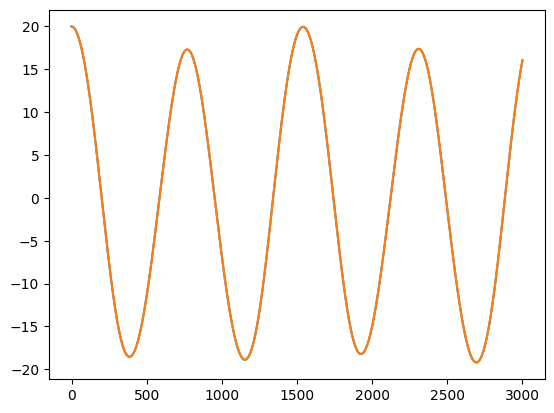

In [36]:
plt.plot(sol.ts,sol.ys[:,0])
plt.plot(pert_Gen.prog_base.ts,pert_Gen.prog_base.ys[0][:,0])

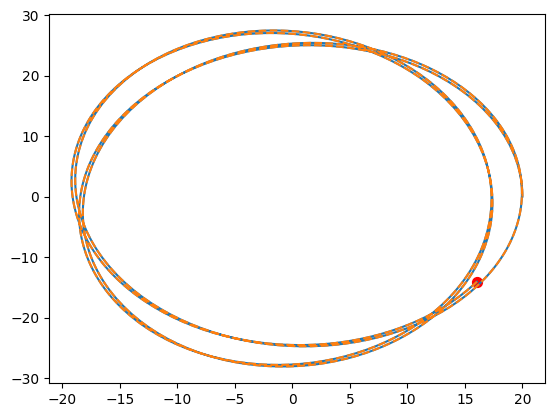

In [37]:
plt.plot(pert_Gen.prog_base.ys[0][:,0],pert_Gen.prog_base.ys[0][:,1])
plt.scatter(sol.ys[-1][0],sol.ys[-1][1],color='r',s=50)
#plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [38]:
pert_Gen.prog_fieldICs.shape

(1000, 10, 12)

In [67]:
pert_Gen.gradientPotentialStructural_per_SH(jnp.array([1,2,.3]), 2300.0)

Array([[ 1.30516960e-18, -4.10822347e-19,  1.09137137e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

In [114]:
tst_field = fields.MassRadiusPerturbation_OTF(pert_Gen)
def integrator(realspace_w0, pert_w0, ts):
    out =  fields.integrate_field(w0=[realspace_w0, pert_w0],ts=ts,field=tst_field).ys
    return [out[0][1], out[1][1]]
#integrator = lambda realspace_w0, pert_w0, ts: fields.integrate_field(w0=[realspace_w0, pert_w0],ts=ts,field=tst_field).ys
grad_integrator = jax.jacfwd(integrator,argnums=(0,))
out1 = grad_integrator(jnp.ones(6), jnp.ones((10,12)), jnp.array([0,10.0]))

gradgrad_integrator = jax.jacfwd(jax.jacfwd(grad_integrator,argnums=(0,)),argnums=(0,))
out2 = gradgrad_integrator(jnp.ones(6), jnp.ones((10,12)), jnp.array([0,10.0]))

In [130]:
out2[1][0][0][0].shape

(10, 12, 6, 6, 6)

In [113]:
integrator(jnp.ones(6), jnp.ones((10,12)), jnp.array([0,10.0]))[1][1].shape

(10, 12)

In [49]:
fc = pert_Gen.base_stream.prog_loc_fwd[-1]#ts[-126]

In [68]:
lead_out_and_derivs, trail_out_and_derivs = pert_Gen.compute_perturbation_OTF(cpu=True, 
solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9,atol=1e-9,dtmin=0.01,dtmax=None)

In [41]:
from perturbative import CustomBaseStreamModel


In [42]:
base_model.prog_loc_fwd.shape

(1000, 6)

In [45]:
pos_close, pos_far, v_close, v_far = base_model.streamICs
close_rel_ICs = jnp.hstack([pos_close, v_close]) - base_model.prog_loc_fwd
far_rel_ICs = jnp.hstack([pos_far, v_far]) - base_model.prog_loc_fwd

total_ics = close_rel_ICs#jnp.vstack([close_rel_ICs, far_rel_ICs])
total_ts = base_model.ts#jnp.hstack([base_model.ts, base_model.ts])




In [46]:
custom_base = CustomBaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=total_ts, pos_rel=total_ics[:,:3], vel_rel=total_ics[:,3:],units=usys)

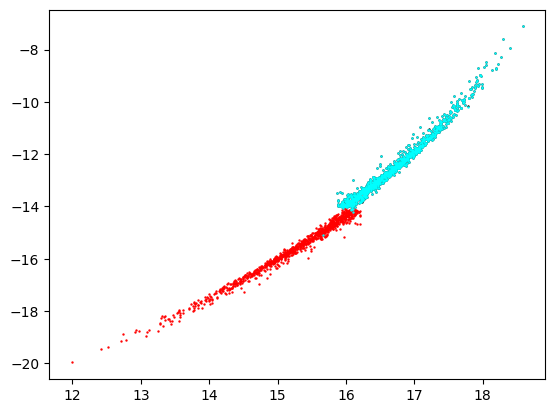

In [53]:
sout_test = custom_base.gen_stream().ys[:,0,:]
ldf, tdf = StreamSculptor.eval_dense_stream(3000.0, ld_td)
plt.scatter(ldf[:,0], ldf[:,1],s=0.5,color='k')
plt.scatter(tdf[:,0], tdf[:,1],s=0.5,color='r')
plt.scatter(sout_test[:,0], sout_test[:,1],s=0.5,color='cyan')

In [57]:
from perturbative import GenerateMassRadiusPerturbation_CustomBase as perturbation_custom

pert_gen_custom = perturbation_custom(potential_base=pot_NFW,potential_perturbation=pot_SH,potential_structural=pot_structural, 
units=usys,BaseStreamModel=custom_base,solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9, atol=1e-9,dtmin=0.01,dtmax=None)

In [59]:
pert_cust_out = pert_gen_custom.compute_perturbation_OTF(solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9, atol=1e-9,dtmin=0.01,dtmax=None)

In [64]:
pert_cust_out[1].shape

(999, 10, 12)

In [88]:
response_tst = pert_cust_out[1][:,0,:]*2e6

In [42]:
#lead_out_and_derivs_, trail_out_and_derivs_ = pert_Gen.compute_perturbation_Interp(cpu=False, 
#solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9,atol=1e-9,dtmin=0.01,dtmax=None)

In [43]:
#lead_out_and_derivs_v, trail_out_and_derivs_v = pert_Gen.compute_perturbation_OTF(cpu=False)

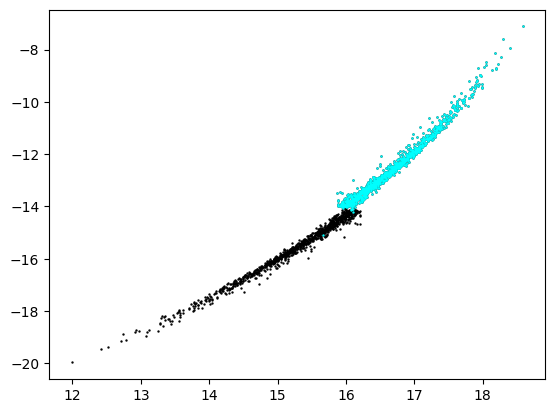

In [71]:
plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(pert_cust_out[0][:,0], pert_cust_out[0][:,1],s=0.5,color='cyan')

#plt.scatter(fc[0],fc[1],color='r',s=20)

#plt.scatter(l[:,0], l[:,1],s=0.5,color='g')
#plt.scatter(t[:,0], t[:,1],s=0.5,color='g')
#plt.scatter(lead_out_and_derivs_v[0][:,0], lead_out_and_derivs_v[0][:,1],s=0.5,color='r')
#plt.scatter(trail_out_and_derivs_v[0][:,0], trail_out_and_derivs_v[0][:,1],s=0.5,color='r')

In [51]:
lead_out_and_derivs[1].shape

(999, 10, 12)

In [52]:
lead_out_and_derivs[0].shape

(999, 6)

(-21.0, -7.0)

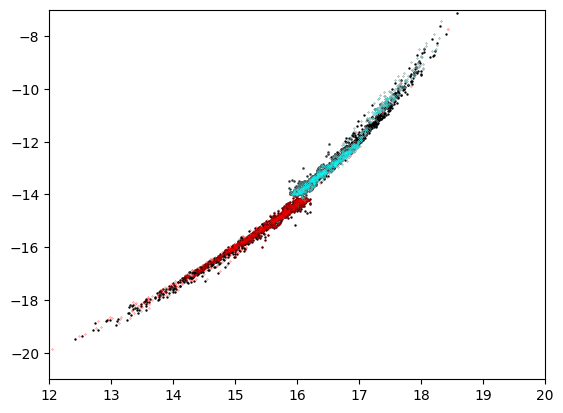

In [89]:

M_sh = 2e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs[1][:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs[1][:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')

plt.scatter(pert_cust_out[0][:,0] +  response_tst[:,0], pert_cust_out[0][:,1] + response_tst[:,1],s=0.05,color='cyan')
#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

In [79]:

M_sh = 2e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs_[:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs_[:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')
#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

NameError: name 'lead_out_and_derivs_' is not defined

In [66]:
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,0]*M_sh,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,0]*M_sh,s=.5)

NameError: name 'M_sh' is not defined

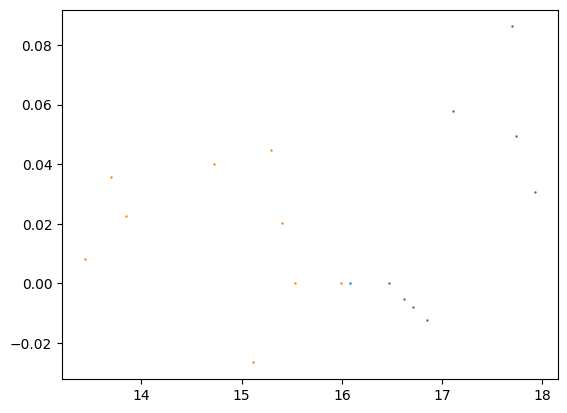

In [48]:
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs_[:,0,0]*M_sh,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs_[:,0,0]*M_sh,s=.5)

In [87]:
response_tst.shape

(999, 6)

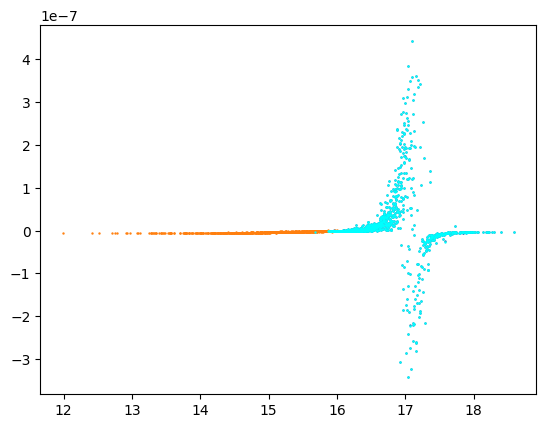

In [93]:
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,6]*1,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,6]*1,s=.5)

plt.scatter( pert_cust_out[0][:,0] ,response_tst[:,6]/2e6,color='cyan',s=.5)

In [81]:
response_tst.shape

(999, 6)

In [114]:
import warnings

# Ignore all warnings
#warnings.simplefilter('ignore')

# Ignore only DeprecationWarnings
#warnings.simplefilter('ignore', category=DeprecationWarning)

# Treat FutureWarnings as errors
#warnings.simplefilter('ignore', category=FutureWarning)

In [115]:
def gen_at_mass(mass):
    pot_SH_single = potential.SubhaloLinePotential(m=jnp.array([mass]), a=jnp.array([a[0]]), subhalo_x0=jnp.array([subhalo_x0[0,:]]),
    subhalo_v=jnp.array([subhalo_v[0,:]]), subhalo_t0=jnp.array([subhalo_t0[0]]), t_window=t_window[0],units=usys)

    prog_wf = pot_NFW.integrate_orbit(w0=w0, ts=jnp.array([ts[0],ts[-1]]), solver=diffrax.Dopri8(scan_kind='bounded')).ys[1]
    pot_lst = [pot_NFW, pot_SH_single]
    pot_total = potential.Potential_Combine(potential_list=pot_lst, units=usys)
    prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


    lead_nonlin, trail_nonlin = StreamSculptor.gen_stream_vmapped_with_pert(pot_base=pot_NFW,pot_pert=pot_SH_single, 
    ts=ts, prog_w0=prog_init, Msat=1e4, seed_num=493, solver=diffrax.Dopri8(scan_kind='bounded'), rtol=1e-9, atol=1e-9,dtmin=0.01, jump_ts=pert_Gen.jump_ts)
    return lead_nonlin, trail_nonlin

l_non, t_non = jax.jacfwd(gen_at_mass)(0.0)


In [116]:
lead_nonlin, trail_nonlin = gen_at_mass(2e6)
stream_nonlin = jnp.vstack([lead_nonlin,trail_nonlin])

In [117]:
lead_unpert, trail_unpert = gen_at_mass(0.0)

In [118]:

M_sh = 2e6
lead_lin_ = lead_out_and_derivs[0] + l_non*M_sh
trail_lin_ = trail_out_and_derivs[0] + t_non*M_sh
stream_lin_ = jnp.vstack([lead_lin_,trail_lin_])

(-21.0, -7.0)

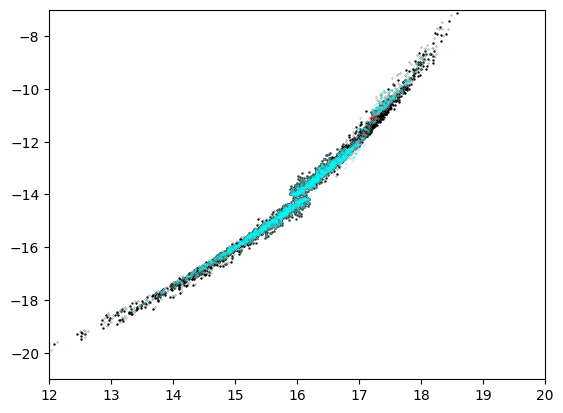

In [119]:

M_sh = 2e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs[1][:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs[1][:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')
plt.scatter(stream_lin_[:,0], stream_lin_[:,1],s=0.05,color='cyan')

#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

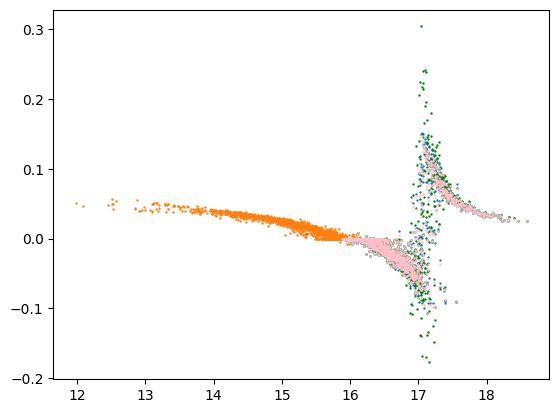

In [123]:
dim = 0
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,dim]*M_sh,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,dim]*M_sh,s=.5)


plt.scatter(lead_out_and_derivs[0][:,0],  l_non[:,dim]*M_sh,s=.5,color='g')

delta_nonlin = lead_nonlin - lead_unpert

plt.scatter(lead_out_and_derivs[0][:,0],  delta_nonlin[:,dim],s=.5,color='pink')


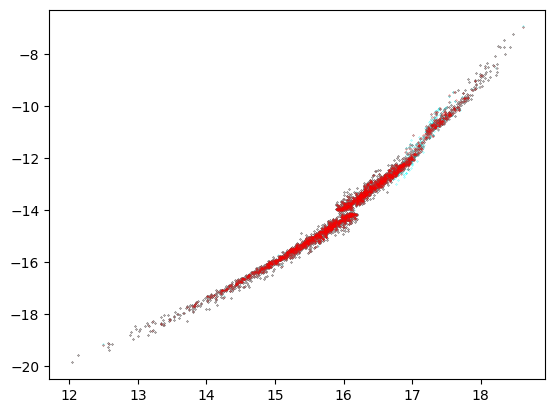

In [124]:
plt.scatter(stream_lin_[:,0], stream_lin_[:,1],s=0.05,color='cyan')
plt.scatter(stream_nonlin[:,0], stream_nonlin[:,1],s=0.05,color='teal')
plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')


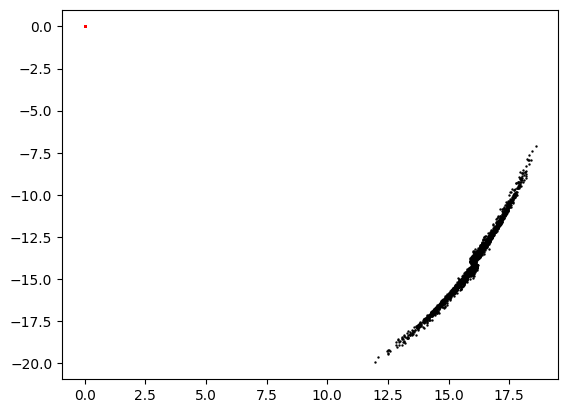

In [127]:

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(l_non[:,0], l_non[:,1],s=0.5,color='r')
plt.scatter(t_non[:,0], t_non[:,1],s=0.5,color='r')

In [128]:
a[0]

Array(0.2, dtype=float64)

In [129]:
def gen_at_mass_radius(mass, radius):
    pot_SH_single = potential.SubhaloLinePotential(m=jnp.array([mass]), a=jnp.array([radius]), subhalo_x0=jnp.array([subhalo_x0[0,:]]),
    subhalo_v=jnp.array([subhalo_v[0,:]]), subhalo_t0=jnp.array([subhalo_t0[0]]), t_window=t_window[0],units=usys)
    prog_wf = pot_NFW.integrate_orbit(w0=w0, ts=jnp.array([ts[0],ts[-1]]), solver=diffrax.Dopri8(scan_kind='bounded')).ys[1]
    pot_lst = [pot_NFW, pot_SH_single]
    pot_total = potential.Potential_Combine(potential_list=pot_lst, units=usys)
    prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


    lead_nonlin, trail_nonlin = StreamSculptor.gen_stream_vmapped_with_pert(pot_base=pot_NFW,pot_pert=pot_SH_single, 
    ts=ts, prog_w0=prog_init, Msat=1e4, seed_num=493, solver=diffrax.Dopri8(scan_kind='bounded'), rtol=1e-9, atol=1e-9,dtmin=0.01, jump_ts=pert_Gen.jump_ts)
    return lead_nonlin, trail_nonlin
dlead_dmass, dtrail_dmass = jax.jacfwd(gen_at_mass_radius,argnums=(0,))(0.0,0.2)
d2lead, d2trail = jax.jacfwd(jax.jacfwd(gen_at_mass_radius,argnums=(0,)),argnums=(1,))(0.0,0.2)

dlead_dmass, dtrail_dmass = dlead_dmass[0], dtrail_dmass[0]
d2lead, d2trail = d2lead[0][0], d2trail[0][0]


(-1e-06, 1e-06)

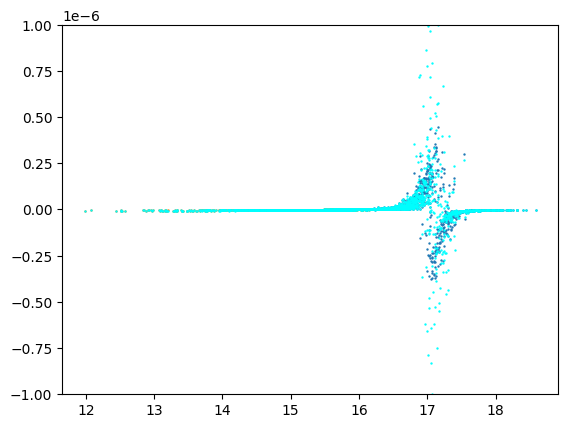

In [138]:
dd=0
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,6+dd]*1,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,6+dd]*1,s=.5)


plt.scatter(lead_out_and_derivs[0][:,0],  d2lead[:,dd]*1,s=.5,color='cyan')
plt.scatter(trail_out_and_derivs[0][:,0],  d2trail[:,dd]*1,s=.5,color='cyan')
plt.ylim(-1e-6,1e-6)


In [138]:
prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


In [139]:
prog_init

Array([ 1.99980532e+01, -2.56099519e-01,  1.99843423e+01,  1.41873880e-03,
        1.99946222e-01,  1.36733644e-03], dtype=float64)

In [28]:
stream_lin.shape

(2998, 6)

In [31]:
lead_out_and_derivs[1]/lead_out_and_derivs_v[1]




Array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [28]:
output[0].ys[0].shape#.ys[1].shape

(1499, 2, 6)

In [35]:
output[0].ys[1].shape

(1499, 2, 10, 12)

In [20]:
pert_Gen.compute_perturbation_ICs()[1].shape

(1500, 10, 12)

In [38]:
pert_Gen.perturbation_ICs[1].shape

(1500, 10, 12)

In [31]:
base_model.streamICs[3].shape

(1500, 3)

In [33]:
 jnp.hstack([base_model.streamICs[0], base_model.streamICs[2]]).shape

(1500, 6)

In [22]:
lout, tout = pert_Gen.compute_base_stream(cpu=False)


In [29]:
base_model.dRel_dIC.shape

(1500, 2, 6, 6)

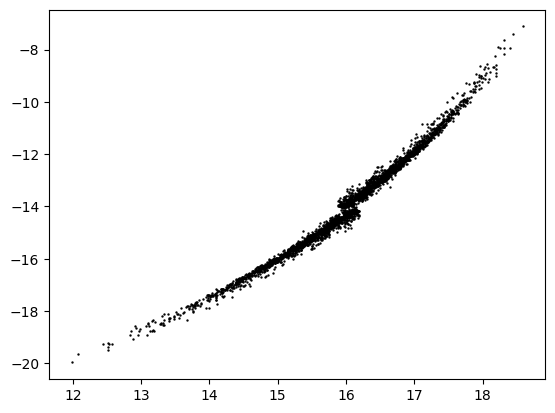

In [23]:
plt.scatter(lout[:,0], lout[:,1],s=0.5,color='k')
plt.scatter(tout[:,0], tout[:,1],s=0.5,color='k')


In [19]:
pert_Gen.fieldICs.ys[1]

(1500, 10, 12)

In [20]:
ts.shape

(1500,)

In [30]:
jnp.sum(pert_Gen.fieldICs.ys[1],axis=1)[2]

Array([-1.35768480e-13,  4.49920989e-15, -1.35768149e-13, -3.87432793e-14,
        1.29758755e-15, -3.87550906e-14,  5.01245915e-16, -1.72591489e-17,
        4.99398722e-16,  1.42980983e-16, -4.97669531e-18,  1.42482560e-16],      dtype=float64)

In [31]:
pert_Gen.jump_ts

Array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float64)

In [ ]:
pot_SH.subhalo_x0.shape

(10, 3)

In [ ]:
pert_Gen.prog_w0

AttributeError: 'GenerateMassRadiusPerturbation' object has no attribute 'prog_w0'

In [ ]:
pert_field = fields.MassRadiusPerturbation_OTF(pert_Gen)



In [ ]:
example_coords = [jnp.hstack([jnp.ones(3),jnp.ones(3)]), 
                jnp.hstack([jnp.ones((10,3)),jnp.ones((10,3)), jnp.ones((10,3)), jnp.ones((10,3))])]
#example_coords[1].shape
pert_field.term(0.0,example_coords, None)

[Array([ 1.        ,  1.        ,  1.        , -0.00290453, -0.00290453,
        -0.00290453], dtype=float64),
 Array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774549e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774549e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774549e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [

In [ ]:
jnp.ones((10,3))

Array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float64)

In [ ]:
pert_Gen.gradientPotentialPerturbation_per_SH(jnp.array([1.,20.,3.]),0.0).shape

(10, 3)

In [ ]:
obj = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, solver=diffrax.Dopri5(scan_kind='bounded') )

In [ ]:
obj.prog_loc_fwd.shape

(1500, 6)

In [ ]:
obj.dRel_dIC

Array([[[[ 9.96418614e-01,  4.87120170e-04, -4.42824880e-05,
          -9.30743752e-02,  1.31131449e-01, -2.19712970e-02],
         [ 1.03703439e-03,  9.96216989e-01,  1.02067057e-04,
           4.18392106e-02,  8.93746158e-02, -1.20250323e-01],
         [ 1.34265400e-03,  8.89893678e-04,  9.96105638e-01,
          -6.74033188e-02,  7.26106414e-02,  3.69975941e-03],
         [ 6.32656012e-06, -4.10394642e-07, -7.62879260e-07,
           1.00013673e+00, -4.93138630e-04,  2.95917439e-04],
         [ 3.56197289e-06, -1.90869969e-06, -3.86061491e-06,
           5.61375084e-04,  1.00018700e+00, -7.25433287e-04],
         [ 2.54819675e-06, -2.46533325e-06, -3.85776049e-06,
          -6.29240028e-04,  3.29080427e-04,  1.00034053e+00]],

        [[ 1.00358139e+00, -4.87120170e-04,  4.42824880e-05,
           9.30743752e-02, -1.31131449e-01,  2.19712970e-02],
         [-1.03703439e-03,  1.00378301e+00, -1.02067057e-04,
          -4.18392106e-02, -8.93746158e-02,  1.20250323e-01],
         [-1.3

In [ ]:
deriv = obj.release_func_jacobian()

In [ ]:
deriv.shape

(1500, 2, 6, 6)

In [ ]:
from genstream import StreamModel
